# Multivariate Linear Regression - Gradient Descent

This notebook shows an implementation of how to solve a multivariable linear regression model using the *gradient descent* algorithm.

### Data Set

The dataset that we will be working with is a 2 variable dataset showing the relationship between the number of years experience that each participant has at their job, and their current salary (one would indeed hope that there was a positive linear relationship there).

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset = pd.read_csv("./data/auto-mpg-data.csv")

print(dataset.iloc[:5, :]) # first 5 rows

X = dataset.iloc[:, 1:-1].values # get the data as a numpy array
y = dataset.iloc[:, :1].values

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model year  origin                   car name  
0          70       1  chevrolet,chevelle,malibu  
1          70       1          buick,skylark,320  
2          70       1         plymouth,satellite  
3          70       1              amc,rebel,sst  
4          70       1                ford,torino  


### The Hypothesis

For a multivariate linear regression model, we take the hypothesis (the shape of our model), to be of the form $h_\theta(x) = \vec{\theta} \cdot \mathbf{x}$. Where

$$\begin{align}
\vec{\theta} &= \theta_0 + \theta_1 + \dots + \theta_n \text{ and,} \\
\mathbf{x} &= x_0 + x_1 \dots + x_n,
\end{align}$$

and by convention we let $x_0 = 1$, making the first term of the dot product $\theta_0$, (i.e. a contant term).

$$
h_\theta(\mathbf{x}) = \vec{\theta} \cdot \mathbf{x} = \theta_0 + \theta_1 x_1 + \dots + \theta_n x_n.
$$

In [76]:
def hypothesis(theta):
    """Curried hypothesis function - this function returns a function to be called on a feature vector
    
    Args:
        theta (numpy array): vector of parameters of the linear regression
    """
    N = len(theta)
    
    def hypothesis_of_X(X):
        """Calculates the predicted value of a feature vector
        
        Args:
            X (numpy array): feature vector
        """
        X = np.insert(X, 0, [1], 0)
        
        if len(X) != N:
            raise ValueError("X is the wrong shape for this hypothesis")
            
        return np.sum(theta * X)
    
    return hypothesis_of_X
        
# sanity check tests
assert hypothesis(np.array([1,1]))(np.array([1])) == 2
assert hypothesis(np.array([1,2]))(np.array([2])) == 5
assert hypothesis(np.array([10,12]))(np.array([3])) == 46
assert hypothesis(np.array([1,-2,3]))(np.array([3,3])) == 4

### The Cost Function

We will implement the *mean squared error* cost function, $J(\theta) = \frac{1}{m} \sum_{i=1}^m ( h_\theta(\mathbf{x}^{(i)}) - y^{(i)} )^2$. i.e. the average of the squared distance from the predicted value to the actual value. (The notation $\mathbf{x}^{(i)}$ is used to denote the $i^{th}$ feature vector.)

In [77]:
def mean_squared_error(X, y):
    """Curried mean squared error (MSE) function
    
    This function returns a function to be called on a feature vector and target value to calculate
    the MSE of the hypothesis with the given parameters theta.
    
    Args:
        theta (numpy array): vector of parameters of the linear regression
    """
    
    def mean_squared_error_of_X_y(theta):
        """
        Args:
            X (numpy array): feature vector
            y (numpy array): target value
        """
        h = hypothesis(theta)
        predictions = np.apply_along_axis(h, 1, X)
        return (1 / X.size) * np.sum((predictions - y.flatten())**2)
    
    return mean_squared_error_of_X_y
    
assert mean_squared_error(np.array([[1],[2],[3]]), np.array([[2],[3],[4]]))(np.array([0,1])) == 1
assert mean_squared_error(np.array([[1],[2],[3]]), np.array([[2],[3],[4]]))(np.array([1,4])) == 42

### Gradient Descent

To implement the gradient descent algorithm we need to calculate the partial differentials of the *cost function*, with respect to each of the $\theta_i$. For the *mean squared error* function,

$$
J(\theta) = \frac{1}{m} \sum_{i=1}^m ( h_\theta(\mathbf{x}^{(i)}) - y^{(i)} )^2
$$

this gives us:

$$\begin{align}
\frac{\partial J}{\partial \theta_j} &= \frac{2}{m} \sum_{i=1}^m x_j^{(i)} ( h_\theta(\mathbf{x}^{(i)}) - y^{(i)} ). \\
\end{align}$$

Using these results we can then perform the incremental updates of

$$
\theta_{j, t+1} = \theta_{j, t} - \alpha \frac{\partial J}{\partial \theta_j}.
$$

In [78]:
def theta_j_partial(X, y):
    """Curried function to calculate the vector of dJ/d(theta_j)
    
    This function returns a function to be called on a theta vector to calculate the gradient vector
    for the cost function with respect to each of the linear regression parameters.
    
    Args:
        X (numpy array): feature vector
        y (numpy array): target value
    """
    
    def J_theta_j_partials(theta):
        """
        Args:
            theta (numpy array): vector of parameters of the linear regression
        """
        rows, cols = X.shape
        X_pad_ones = np.ones((rows, cols + 1))
        X_pad_ones[:, 1:] = X
        h = hypothesis(theta)
        predictions = np.apply_along_axis(h, 1, X)
        errors = predictions - y.T
        return (2 / X.size) * np.sum((X_pad_ones.T * errors), axis=1)
    
    return J_theta_j_partials

In [79]:
def fit_linear_regression_model(X, y, theta=(0,1), alpha=0.01):
    """Function to train a linear regression model
    
    A function to train a linear regression model on feature vectors X and output vector y.
    The function displays the steps of the training, and returns the learned value of the model's parameters, theta.
    
    Args:
        X (numpy array): feature vector
        y (numpy array): target value
        theta (numpy array): initial values of the parameters for the model
        alpha (float): the learning rate
    """
    
    step_gradient_descent = get_step_gradient_descent(X, y, alpha)
    step = 0
    error_change_threshold = 0.1
    mse = mean_squared_error(X, y)
    error = mse(theta)
    error_change = error
    print(f"step {step}: theta = {theta}, mse = {error}, error change = {error_change}")
    while abs(error_change) > error_change_threshold:
        step += 1
        theta = step_gradient_descent(theta)
        new_error = mse(theta)
        error_change = error - new_error
        error = new_error
        print(f"step {step}: theta = {np.round(theta, 2)}, mse = {round(error)}, error change = {round(error_change)}")
    print(f"returning after {step} steps...")
    print(f"theta = {theta}")
    return theta
        

In [86]:
theta = fit_linear_regression_model(X, y, theta=(0,1,1,1,1,1,1,1), alpha=0.00000001)

h = hypothesis(theta)

#y_prime = h(X)
y_prime = np.apply_along_axis(h, 1, X)

step 0: theta = (0, 1, 1, 1, 1, 1, 1, 1), mse = 1743489.8189176386, error change = 1743489.8189176386
step 1: theta = [-0.    1.    1.    1.    0.97  1.    1.    1.  ], mse = 1648706.0, error change = 94784.0
step 2: theta = [-0.    1.    1.    1.    0.94  1.    1.    1.  ], mse = 1559077.0, error change = 89630.0
step 3: theta = [-0.    1.    0.99  1.    0.91  1.    1.    1.  ], mse = 1474321.0, error change = 84756.0
step 4: theta = [-0.    1.    0.99  1.    0.88  1.    1.    1.  ], mse = 1394174.0, error change = 80147.0
step 5: theta = [-0.    1.    0.99  0.99  0.85  1.    1.    1.  ], mse = 1318385.0, error change = 75789.0
step 6: theta = [-0.    1.    0.99  0.99  0.83  1.    1.    1.  ], mse = 1246717.0, error change = 71668.0
step 7: theta = [-0.    1.    0.99  0.99  0.8   1.    1.    1.  ], mse = 1178946.0, error change = 67771.0
step 8: theta = [-0.    1.    0.98  0.99  0.78  1.    0.99  1.  ], mse = 1114861.0, error change = 64086.0
step 9: theta = [-0.    1.    0.98  0.99  

step 80: theta = [-0.    1.    0.93  0.96 -0.    1.    0.98  1.  ], mse = 20288.0, error change = 1144.0
step 81: theta = [-0.    1.    0.93  0.96 -0.    1.    0.98  1.  ], mse = 19206.0, error change = 1082.0
step 82: theta = [-0.    1.    0.93  0.96 -0.01  1.    0.98  1.  ], mse = 18183.0, error change = 1023.0
step 83: theta = [-0.    1.    0.93  0.96 -0.01  1.    0.98  1.  ], mse = 17215.0, error change = 967.0
step 84: theta = [-0.    1.    0.93  0.96 -0.01  1.    0.98  1.  ], mse = 16300.0, error change = 915.0
step 85: theta = [-0.    1.    0.93  0.96 -0.02  1.    0.98  1.  ], mse = 15435.0, error change = 865.0
step 86: theta = [-0.    1.    0.93  0.96 -0.02  1.    0.98  1.  ], mse = 14617.0, error change = 818.0
step 87: theta = [-0.    1.    0.93  0.96 -0.02  1.    0.98  1.  ], mse = 13844.0, error change = 774.0
step 88: theta = [-0.    1.    0.93  0.96 -0.03  1.    0.98  1.  ], mse = 13112.0, error change = 732.0
step 89: theta = [-0.    1.    0.93  0.96 -0.03  1.    0.98  

step 161: theta = [-0.    1.    0.92  0.96 -0.11  0.99  0.97  1.  ], mse = 605.0, error change = 12.0
step 162: theta = [-0.    1.    0.92  0.96 -0.11  0.99  0.97  1.  ], mse = 593.0, error change = 12.0
step 163: theta = [-0.    1.    0.92  0.96 -0.11  0.99  0.97  1.  ], mse = 582.0, error change = 11.0
step 164: theta = [-0.    1.    0.92  0.96 -0.11  0.99  0.97  1.  ], mse = 572.0, error change = 10.0
step 165: theta = [-0.    1.    0.92  0.96 -0.11  0.99  0.97  1.  ], mse = 562.0, error change = 10.0
step 166: theta = [-0.    1.    0.92  0.96 -0.11  0.99  0.97  1.  ], mse = 553.0, error change = 9.0
step 167: theta = [-0.    1.    0.92  0.96 -0.11  0.99  0.97  1.  ], mse = 544.0, error change = 9.0
step 168: theta = [-0.    1.    0.92  0.96 -0.11  0.99  0.97  1.  ], mse = 536.0, error change = 8.0
step 169: theta = [-0.    1.    0.92  0.96 -0.11  0.99  0.97  1.  ], mse = 528.0, error change = 8.0
step 170: theta = [-0.    1.    0.92  0.96 -0.11  0.99  0.97  1.  ], mse = 520.0, erro

step 245: theta = [-0.    1.    0.92  0.96 -0.12  0.99  0.97  1.  ], mse = 392.0, error change = 0.0
step 246: theta = [-0.    1.    0.92  0.96 -0.12  0.99  0.97  1.  ], mse = 392.0, error change = 0.0
step 247: theta = [-0.    1.    0.92  0.96 -0.12  0.99  0.97  1.  ], mse = 392.0, error change = 0.0
step 248: theta = [-0.    1.    0.92  0.96 -0.12  0.99  0.97  1.  ], mse = 391.0, error change = 0.0
step 249: theta = [-0.    1.    0.92  0.96 -0.12  0.99  0.97  1.  ], mse = 391.0, error change = 0.0
returning after 249 steps...
theta = [-3.42724073e-04  9.97929587e-01  9.20811158e-01  9.59835788e-01
 -1.19639597e-01  9.94857458e-01  9.74125386e-01  9.99517589e-01]


In [ ]:
#for a in np.linspace(0, 0.05, 20):
#    fit_linear_regression_model(X, y, theta=(0,1), alpha=a)

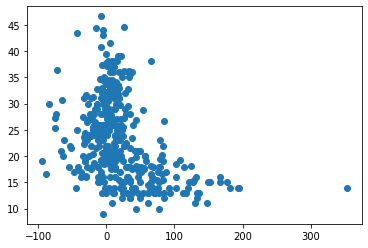

In [87]:
%matplotlib inline

fig = plt.figure()
ax = fig.subplots()
ax.scatter(y_prime, y)
#ax.plot(X, y_prime)
plt.show()